In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

from pywsi.normalization import MacenkoNormalization
from pywsi.normalization import ReinhardNormalization
from pywsi.normalization import VahadaneNormalization


from pywsi.io import WSIReader
from pywsi.io.operations import read_as_rgb
import numpy.linalg as LA
from skimage.filters import try_all_threshold

from sklearn.decomposition import NMF
from sklearn.decomposition import nmf
from sklearn.linear_model import Lasso

from skimage.io import imshow
from sklearn.utils.testing import assert_array_almost_equal
from sklearn.utils.testing import assert_almost_equal
from skimage.filters import threshold_otsu

from pywsi.morphology.operations import open_close, close_open, imerode, imdilate, imopening, imclosing

from numpy import linalg as LA
from skimage.color import rgb2gray, gray2rgb
import spams
from scipy import ndimage as ndi

from skimage.feature import canny


def fractal_dimension(Z, threshold=0.9):

    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])


    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]


Populating the interactive namespace from numpy and matplotlib


/Z/personal-folders/interns/saket/github/pywsi/pywsi/normalization/macenko.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/saket/anaconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/saket/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/saket/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/saket/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/saket/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
  

In [2]:
normal = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/normal/normal_100.tif'
tumor = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/tumor/tumor_004.tif'

tumor_wsi = WSIReader(tumor, 40)
normal_wsi = WSIReader(normal, 40)

In [3]:
x0 = int(59792/2)#30000
y0 = int(233184/2)
tumor_rgb = tumor_wsi.get_patch_by_level(x0, y0, level=0, patch_size=128)

x0 = int(97792/2)
y0 = int(212992/1.5)
normal_rgb = normal_wsi.get_patch_by_level(x0, y0, level=0, patch_size=128)

Text(0.5,1,'Normal')

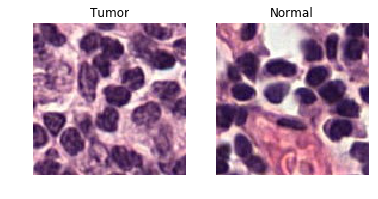

In [48]:
fig = plt.figure()
ax = plt.subplot(121)
ax.set_axis_off()
ax.imshow(tumor_rgb)
ax.set_title('Tumor')

ax = plt.subplot(122)
ax.set_axis_off()
ax.imshow(normal_rgb)
ax.set_title('Normal')


# Normalization

In [52]:
macenko_fit = MacenkoNormalization()
macenko_fit.fit(np.asarray(tumor_rgb).astype(np.uint8))
normalized_rgb_m = macenko_fit.transform(np.asarray(normal_rgb).astype(np.uint8))

In [53]:
vahadane_fit = VahadaneNormalization()
vahadane_fit.fit(np.asarray(tumor_rgb).astype(np.uint8))
normalized_rgb_v = vahadane_fit.transform(np.asarray(normal_rgb).astype(np.uint8))

In [49]:
reinhard_fit = ReinhardNormalization()
reinhard_fit.fit(np.asarray(tumor_rgb).astype(np.uint8))
normalized_rgb_r = reinhard_fit.transform(np.asarray(normal_rgb).astype(np.uint8))

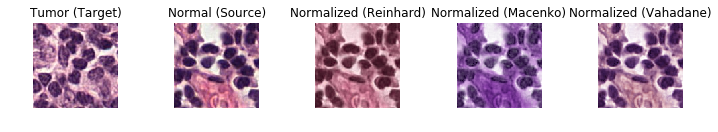

In [57]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(151)
ax.set_axis_off()
ax.imshow(tumor_rgb)
ax.set_title('Tumor (Target)')

ax = plt.subplot(152)
ax.set_axis_off()
ax.imshow(normal_rgb)
ax.set_title('Normal (Source)')

ax = plt.subplot(153)
ax.set_axis_off()
ax.imshow(normalized_rgb_r)
ax.set_title('Normalized (Reinhard)')


ax = plt.subplot(154)
ax.set_axis_off()
ax.imshow(normalized_rgb_m[0])
ax.set_title('Normalized (Macenko)')

ax = plt.subplot(155)
ax.set_axis_off()
ax.imshow(normalized_rgb_v[0])
ax.set_title('Normalized (Vahadane)')

fig.tight_layout()

In [60]:
H_channel_m = macenko_fit.get_hematoxylin_channel(tumor_rgb)
E_channel_m = macenko_fit.get_eosin_channel(tumor_rgb)


H_channel_v = vahadane_fit.get_hematoxylin_channel(tumor_rgb)
E_channel_v = vahadane_fit.get_eosin_channel(tumor_rgb)



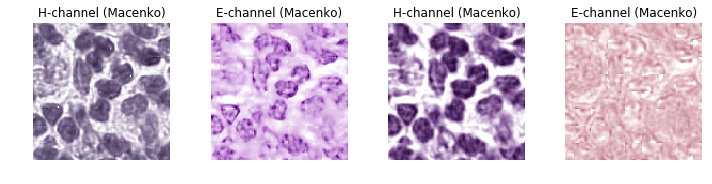

In [61]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(141)
ax.set_axis_off()
ax.imshow(H_channel_m/255)
ax.set_title('H-channel (Macenko)')

ax = plt.subplot(142)
ax.set_axis_off()
ax.imshow(E_channel_m/255)
ax.set_title('E-channel (Macenko)')

ax = plt.subplot(143)
ax.set_axis_off()
ax.imshow(H_channel_v/255)
ax.set_title('H-channel (Macenko)')

ax = plt.subplot(144)
ax.set_axis_off()
ax.imshow(E_channel_v/255)
ax.set_title('E-channel (Macenko)')

fig.tight_layout()

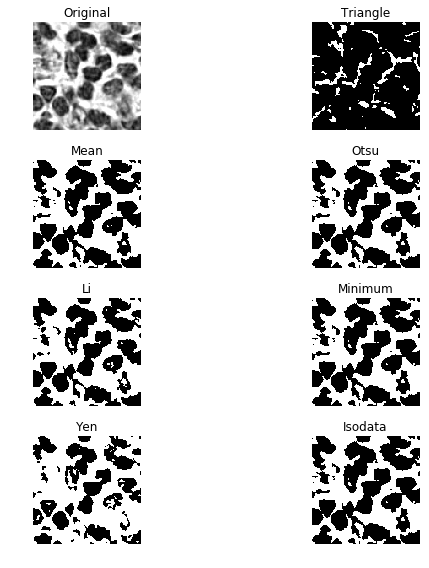

In [62]:
fig, ax = try_all_threshold(rgb2gray(H_channel_v), figsize=(10, 8), verbose=False)


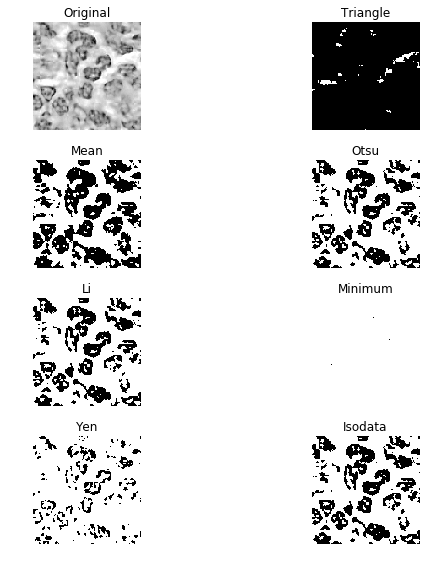

In [22]:
fig, ax = try_all_threshold(rgb2gray(E_channel), figsize=(10, 8), verbose=False)


array([171.62313574, 105.78798323, 196.04789787])

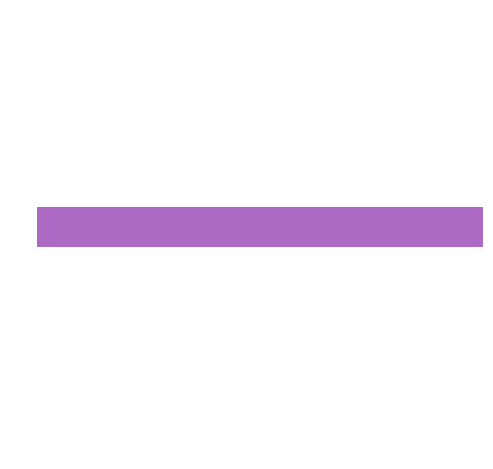

In [63]:
macenko_fit.get_eosin_stain()

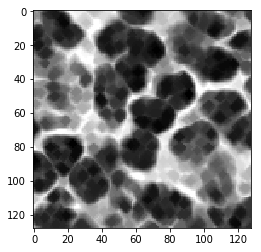

In [23]:
eroded = imerode(rgb2gray(H_channel_v), 2)
plt.imshow(eroded, cmap='gray')

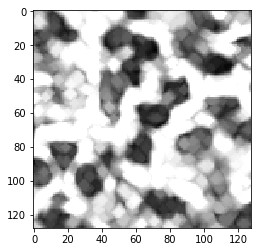

In [24]:
dilated = imdilate(rgb2gray(H_channel_v), 2)
plt.imshow(dilated, cmap='gray')

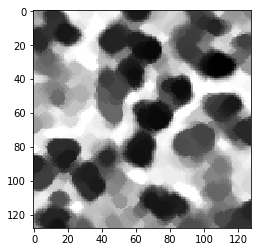

In [25]:
oc = open_close(rgb2gray(H_channel_v), 2, 4)
plt.imshow(oc, cmap='gray')

In [26]:
 threshold_otsu(oc)

155.6417527437384

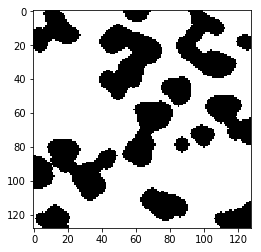

In [27]:

plt.imshow(oc > 0.7*threshold_otsu(oc), cmap='gray')

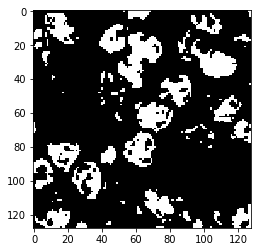

In [28]:
plt.imshow(rgb2gray(H_channel) < 100, cmap='gray')

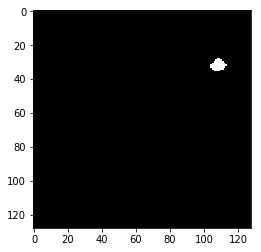

In [29]:
t = rgb2gray(H_channel) < 100
plt.imshow(imclosing(imopening(imerode(imerode(t, 2, True), 2, True), 2), 4), cmap='gray')

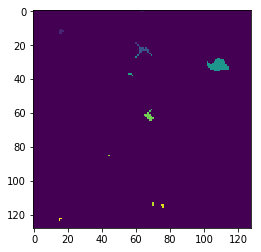

In [30]:
i = imerode(imerode(t, 2), 2)
labeled, x = ndi.label(i)
plt.imshow(labeled)

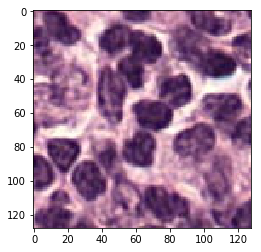

In [31]:
plt.imshow(tumor_rgb
          )

# Extreme example

In [33]:
i3 = read_as_rgb('../data/images/i3.png')

In [34]:
macenko_fit = MacenkoNormalization()
macenko_fit.fit(np.asarray(i3).astype(np.uint8))
H_channel = macenko_fit.get_hematoxylin_channel(i3)


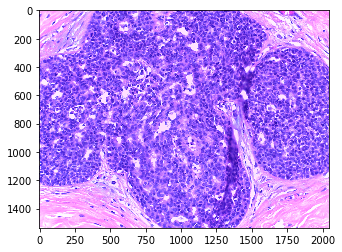

In [35]:
plt.imshow(i3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


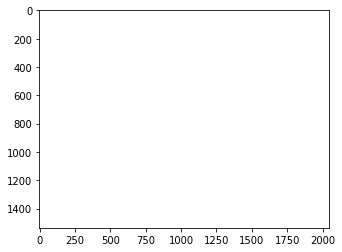

In [36]:
plt.imshow(H_channel, cmap='gray')

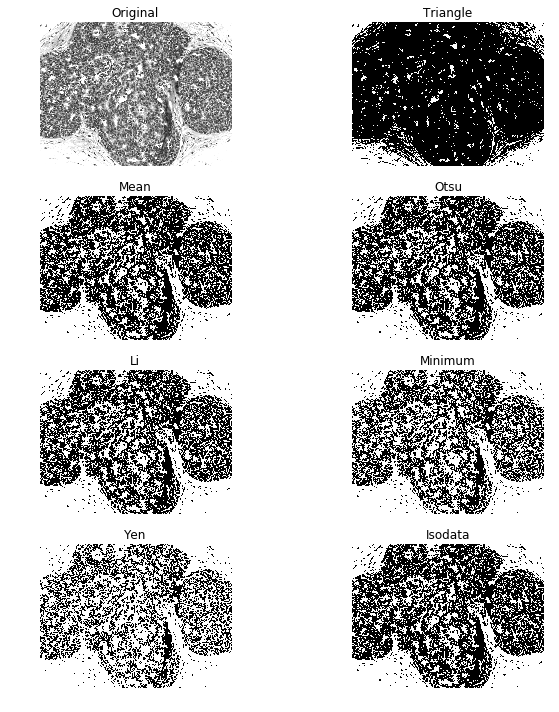

In [37]:
fig, ax = try_all_threshold(rgb2gray(H_channel), figsize=(10,10), verbose=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


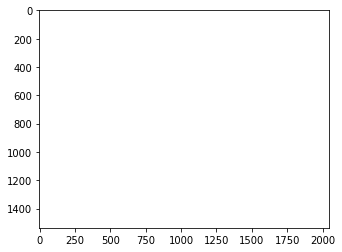

In [38]:
E_channel = macenko_fit.get_eosin_channel(i3)

plt.imshow(E_channel, cmap='gray')

In [39]:
v = read_as_rgb('../data/images/vahadane_ex.png')

In [40]:
macenko_fit = MacenkoNormalization()
macenko_fit.fit(np.asarray(v).astype(np.uint8))
normalized_rgb = macenko_fit.transform(np.asarray(v).astype(np.uint8))

In [41]:
vahadane_fit = VahadaneNormalization()
vahadane_fit.fit(np.asarray(v).astype(np.uint8))
normalized_rgb_v = vahadane_fit.transform(np.asarray(v).astype(np.uint8))

In [43]:
H_channel = macenko_fit.get_hematoxylin_channel(v)
E_channel = macenko_fit.get_eosin_channel(v)

H_channel_v = vahadane_fit.get_hematoxylin_channel(v)
E_channel_v = vahadane_fit.get_eosin_channel(v)

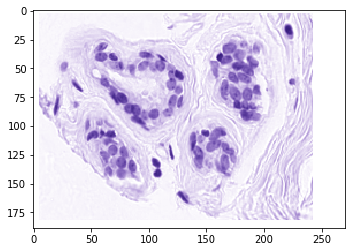

In [44]:
plt.imshow(H_channel/255)

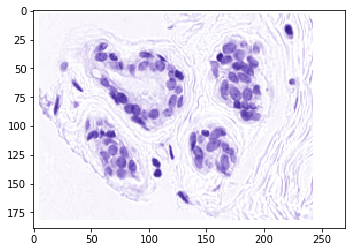

In [45]:
plt.imshow(H_channel_v/255)

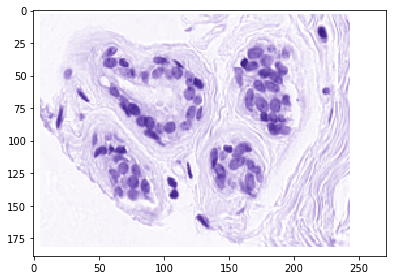

In [46]:
imshow(gray2rgb(H_channel/255))

In [ ]:
E_channel.shape

In [ ]:
H_channel.shape

In [ ]:
macenko_fit.get_eosin_stain()

In [ ]:
macenko_fit.get_hematoxylin_stain()